Statistics has always been a major part of baseball, and today advanced metrics is a major part of the game.  The fielding shift is a regular part of the game today and came about by understanding the advanced metrics of hitters and where they tend to hit the ball.  But, care has to be taken; statistics can also say what you want them to say... "When I negotiated Bob Stanley's contract with the Red Sox, we had statistics demonstrating he was the third-best pitcher in the league. They had a chart showing he was the sixtieth-best pitcher on the Red Sox!" - Agent Bob Woolf

The game of baseball and its statistics are forever linked, and I find that facinating.  However,not everyone does, and that's ok.  "Statistics are about as interesting as first base coaches." - Pitcher Jim Bouton.  My brothers and friends debate the St. Louis Cardinals all summer long and throw statistics around on pitchers, batters and fielders like they were dinner rolls.  And we love it!

This project has taken me on a journey.  It started with defining a topic and asking questions to be answered about the topic.  I chose major league baseball and I have two main questions:

1)  Paul Goldschmidt was recently signed by the St. Louis Cardinals for a 130 million dollars for five years.  It was clearly a good deal for Paul, but was it a good deal for the St. Louis Cardinals.  When does a player's batting performance start to decline amongst high performers in major league baseball?  Does Paul Goldschmidt fit the trend?  I would like to take this further and create a model to predict the optimal signing time and duration time of future super stars given the predictability of batting performance.  As was shown in data discovery, the super deals in major league baseball were not very good deals for the owners, but they were great for the players.

2)  I know there has been a lot of analysis on the steroid era in baseball, but I wanted to find out for myself.  Unfortunately, there is no clear start or end to the steroid era.  ESPN says is likely started in the later 80's and went into the late 2000's.   Others say 1993 to 2003 when MLB introduced performance enhancing drug testing.  Was there a clear advantage during this time for position players and batting performance?  What's at stake for the players who played in that era, especially the high performers... it is MLB's Hall of Fame.  Voters are shying away from voting in players in that era who were either suspected or admitted use of steroids.  They should not rush to judgement.

I set out to answer these questions and started with acquiring the data and found the Layman data set for baseball which provides baseball information from 1871 to 2018.  Data wrangling was performed on the data to get it into the format needed.  All position player batting information from 1954 to 2018 was used.  After that, for data validation, the FanGraphs API was used to validate the wrangled Layman data in a DataFrame format.  FanGraphs is a baseball statistics site providing a variety of statistics pertaining to baseball players.  Data visualization was then performed against the information.  Please see the following link for data visualization, if you have not already done so.  John Tukey an accomplished American statistician once said "The greatest value of a picture is when it forces us to notice what we never expected to see."

https://nbviewer.jupyter.org/github/paulscheibal/SBDataScienceCert/blob/master/CapstoneP1/Discovery/DataStory.ipynb

Let's start our statistics journey with a view of the distribution of players and OPS performance.  Is it normally distributed? First, we show a histogram of the baseball OPS performance including all position players from 1954 to 2018 with a theoritical normal distribution.  To get a better idea from a visual perspective, an Empirical Cumulative Distribution Function using the Layman data is plotted with the theoretical normal CDF and a QQ Plot is created.  It does not look like it is a normal distribution.  Finally, two tests for normality are run (DAgostinos K^2 and Darling Anderson Tests) which shows that the distrbution does not appear to be normally distributed.  




The sample mean of the data is : 0.6767 with sample std dev : 0.168

The size of the sample is 31570





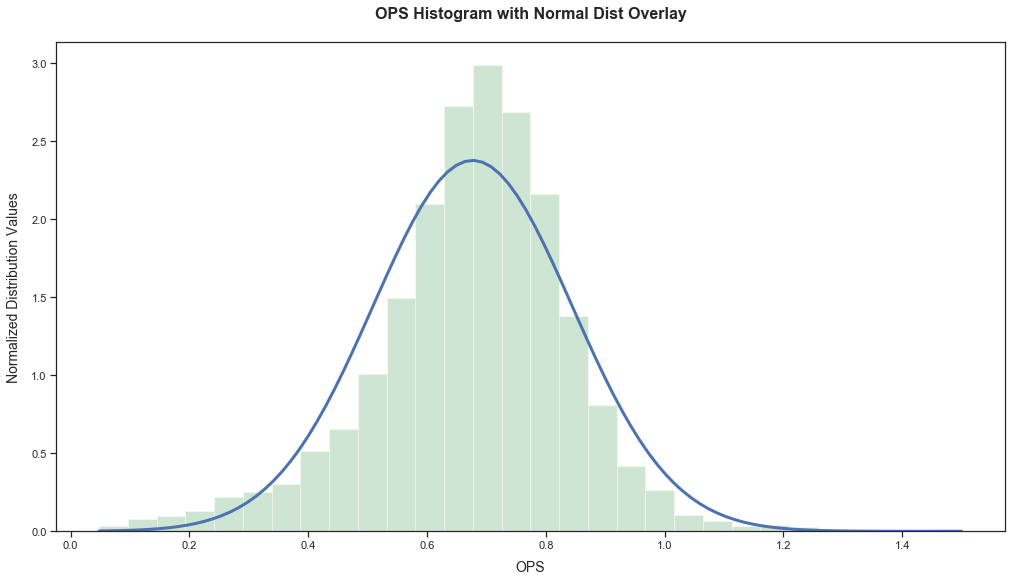

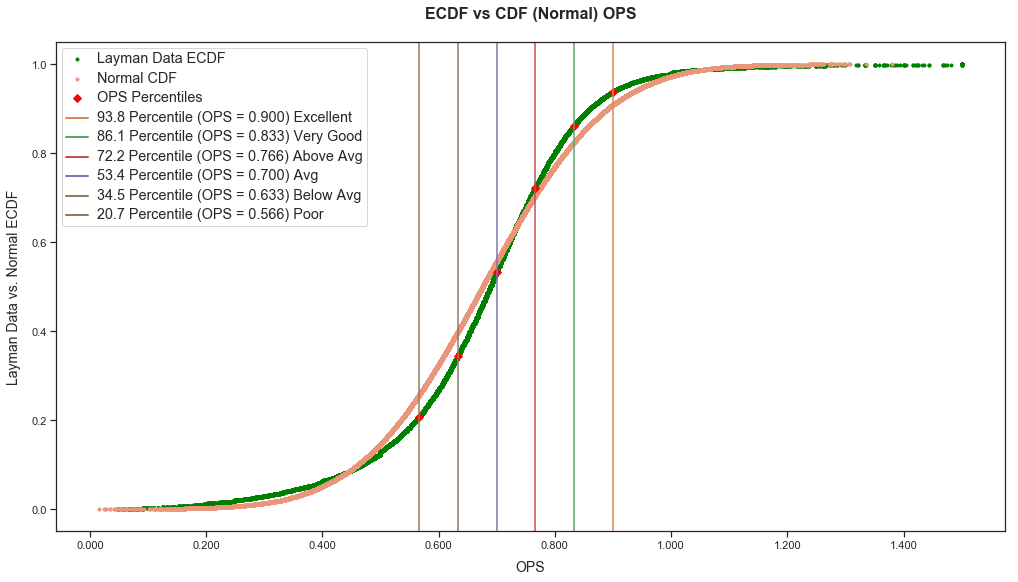

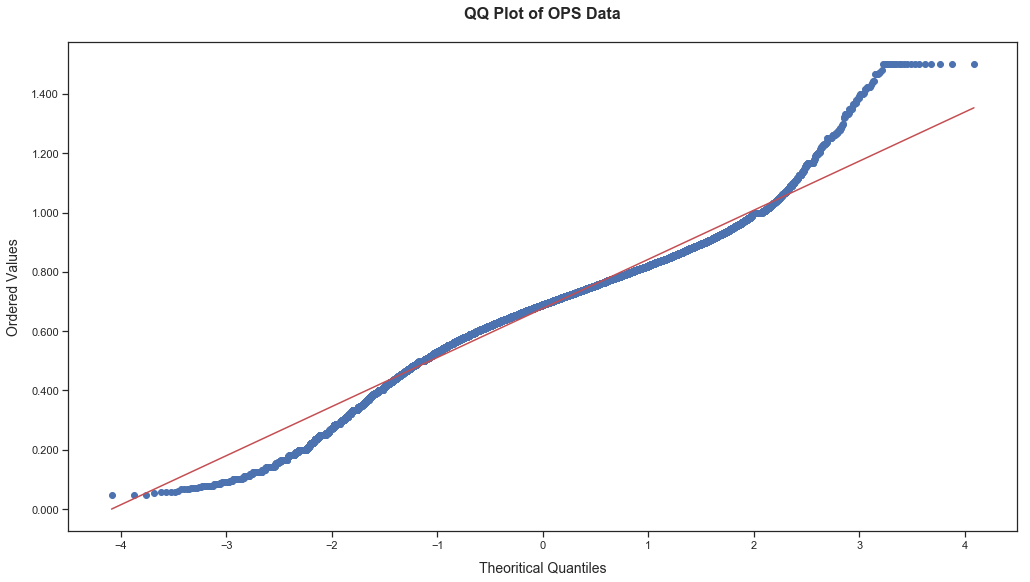




Two Tests for Null Hypothesis (H0) that Layman OPS population data is Normal


DAgostinos K^2 Test:

Statistics=1630.113, p=0.000
Data does not look normal (reject H0)


Anderson Darling Test:

Statistic: 217.140
15.000: 0.576, Data does not look normal (reject H0)
10.000: 0.656, Data does not look normal (reject H0)
5.000: 0.787, Data does not look normal (reject H0)
2.500: 0.918, Data does not look normal (reject H0)
1.000: 1.092, Data does not look normal (reject H0)





In [22]:
# -*- coding: utf-8 -*-
"""
Created on Wed Sep 18 12:31:14 2019

@author: Paul Scheibal
#
#  This program runs a set of statistical tests both statistical and visual
#  in or to better understand the baseball batting data from 1954 to 2018
#  I am mainly interested in OPS data
#
"""

import pandas as pd
import numpy as np
from datetime import datetime
import os.path
import matplotlib.pyplot as plt
import matplotlib.ticker as mtick
import matplotlib as mpl
import pylab as plb
import seaborn as sns
import matplotlib.mlab as mlab
from scipy.stats import norm
from scipy.stats import shapiro
from scipy.stats import anderson
from scipy.stats import normaltest
from scipy.stats import probplot
import math
from numpy.random import seed
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf
from IPython.core.pylabtools import figsize
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import IsolationForest
from sklearn.svm import OneClassSVM

sns.set()
sns.set_style('ticks')

MIN_AT_BATS = 0
START_YEAR = 1954
END_YEAR = 2018
FSHZ = 17
START_DATE = datetime.strptime(str(START_YEAR)+'-01-01','%Y-%m-%d')
END_DATE = datetime.strptime(str(END_YEAR)+'-12-31','%Y-%m-%d')
LEGEND_PROPERTIES = {'weight':'bold'}
 

# set path for reading Lahman baseball statistics
path = 'C:\\Users\\User\\Documents\\PAUL\\Springboard\\core\\'

battingf = path + 'dfbatting_player_stats.csv'
dfbatting_player_stats = pd.read_csv(battingf,parse_dates=['debut','finalGame','birthdate'])

dfbatting_player_stats = dfbatting_player_stats[(dfbatting_player_stats['debut'] >= START_DATE) &
                                                (dfbatting_player_stats['finalGame'] <= END_DATE)]

df = dfbatting_player_stats

# saves a excel file to disk from a dataframe
def save_stats_file(path, fn, df):
    stf = path + fn
    df.to_csv(stf, index=None, header=True)
    return True

#routine that calculates OPS, OBP and SLG and returns them to calling routine.
def calc_ops(df):    
    df['1B'] = df['H'] - ( df['2B'] + df['3B'] + df['HR'] )  
    df['TB'] =  df['1B'] + (df['2B'] * 2) + (df['3B'] * 3) + (df['HR'] * 4)                             
    df['SLG'] = df['TB'] / df['AB']
    df['OBP'] = ( df['H'] + df['BB'] + df['HBP'] ) / ( df['AB'] + df['BB'] + df['SF'] + df['HBP'] )                 
    df['OPS'] = df['OBP'] + df['SLG'] 
    df['AVG'] = df['H'] / df['AB']
    return  df

# ECDF function
def ecdf(data):
    x = np.sort(data)
    n = len(x)
    y = np.arange(1,n+1) / n
    return x,y    

#covariance calculation
def myCovariance(xs, ys):
    meanx = np.mean(xs)
    meany = np.mean(ys)
    n = len(xs)
    prod = (xs - meanx) * (ys - meany)
    cov = sum(prod) / n
    return cov

# given cov calc pearson corr
def myPearson_Corr(cov, xs, ys):
    stdx = np.std(xs)
    stdy = np.std(ys)
    pcorr = cov/(stdx * stdy)
    return pcorr

def OPS_samples(ind):
    return np.random.choice(ind, len(ind))

def ind_samples(ind,n):
    return random.sample(range(len(ind)-1), n)
    
def bootstrap_replicate_wor(df,func,n):
    ind = ind_samples(df.index,n)
    dfnew = df.loc[ind,:]
    return func(dfnew) 

def bootstrap_replicate_wr(df,func):
    ind = OPS_samples(df.index)
    dfnew = df.loc[ind,:]
    return func(dfnew)

def perm_replicate_mean(arr1, arr2):
    lenarr1 = len(arr1)
    botharr = np.concatenate((arr1,arr2))
    botharr_permr = np.random.permutation(botharr)
    arr1x = botharr_permr[:lenarr1]
    arr2x = botharr_permr[lenarr1:]
    return arr1x, arr2x

def perm_replicates_mean(arr1,arr2,m=1):
    OPSarr1_permr = np.empty(m)
    OPSarr2_permr = np.empty(m)
    OPSarr_diff = np.empty(m)
    
    for i in range(m):
        arr1_permr, arr2_permr = perm_replicate_mean(arr1,arr2)
        OPSarr1_permr[i] = np.mean(arr1_permr)
        OPSarr2_permr[i] = np.mean(arr2_permr)
        OPSarr_diff[i] = OPSarr2_permr[i]- OPSarr1_permr[i]        
    return OPSarr1_permr, OPSarr2_permr, OPSarr_diff  

def bs_replicate_1d(data,func):
    return func(np.random.choice(data,size=len(data)))

def choice_replicates(data,func,size):
    bs_replicates = np.empty(size)
    for i in range(size):
        bs_replicates[i] = bs_replicate_1d(data,func)
    return(bs_replicates)

def OPS_val(df):
    df['groupval'] = 1
    df = df.groupby('groupval').sum()
    df = calc_ops(df)
    df = df.reset_index()
    data = df['OPS']
    return data[0]

def calc_poly(x_data,y_data,type):
    coef= np.polyfit(x_data, y_data, type)
    polynomial = np.poly1d(coef)
    x = np.arange(min(x_data),max(x_data) + 1,1)
    y = polynomial(x)
    return coef,x,y

def ecdf_plot_replicates(df,m,clr):
    data = np.array([bootstrap_replicate_wr(df,OPS_val) for i in range(m)])
    mu = np.mean(data)
    sigma = np.mean(data)
    x_ops, y_ops = ecdf(data)
    plt.plot(x_ops,y_ops,marker='.',linestyle='none',color=clr,alpha=.7)
    return True

# set figure size
fig_size = plt.rcParams['figure.figsize']
fig_size[0] = FSHZ
fig_size[1] = 9
plt.rcParams["figure.figsize"] = fig_size

## read in file of some of the bigger contracts in MLB from 1970's to current.
#bigcontractsf = path + bigcontractsfile
#dfbig = pd.read_csv(bigcontractsf)
#
#############################################################################################################
#
#  plot the histogram from layman data against the normal distribution and layman ECDF against the norm CDF
#
#############################################################################################################
# 
# histogram wiht normal distribution with layman mean and standard deviation

df = df[(df['OPS'] <= 1.5) & (df['OPS'] > 0.0)]
data = np.array(df.OPS)
mu = np.mean(data)
sigma = np.std(data)

print('\n\n')
print('The sample mean of the data is : %1.4f' % mu + ' with sample std dev : %1.3f' % sigma)
print('')
print('The size of the sample is ' + str(len(data)))
print('\n\n')

_ = plt.hist(data, bins=30, alpha=0.4, density=True, color='#86bf91')
x = np.linspace(min(data), max(data), 100)
y = norm.pdf(x, mu, sigma)
_ = plt.plot(x, y, linewidth = 3)
_ = plt.title('OPS Histogram with Normal Dist Overlay\n',weight='bold', size=16)
_ = plt.xlabel('OPS', labelpad=10, size=14)
_ = plt.ylabel('Normalized Distribution Values', labelpad=10, size = 14)
plt.show()

# ECDF and norma; CDF
x_ops, y_ops = ecdf(data)
sample = np.random.normal(mu, sigma, size=100000)
x_n, y_n = ecdf(sample)
ptiles = np.array([20.7,34.5,53.4,72.2,86.1,93.8])
ptiles_vals = np.percentile(x_ops,ptiles)
_ = plt.plot(x_ops,y_ops,marker='.',linestyle='none',color='green', label='Layman Data ECDF')
_ = plt.plot(x_n, y_n, marker='.',linestyle='none', label = 'Normal CDF',color='darksalmon')
_ = plt.plot(ptiles_vals, ptiles/100,marker='D',color='red',linestyle='none', label='OPS Percentiles')
_ = plt.title('ECDF vs CDF (Normal) OPS\n',weight='bold', size=16)
_ = plt.xlabel('OPS', labelpad=10, size=14)
_ = plt.ylabel('Layman Data vs. Normal ECDF', labelpad=10, size = 14)
ptiles_str =  [str( '%1.3f' % ptiles_vals[i] ) for i in range(0,len(ptiles))]
ptiles_leg = [str(ptiles[i]) + ' Percentile (OPS = ' + ptiles_str[i] + ')' for i in range(0,len(ptiles))]
plb.axvline(ptiles_vals[5],c='C1',label=ptiles_leg[5] + ' Excellent', color='#ff9999')
plb.axvline(ptiles_vals[4],c='C2',label=ptiles_leg[4] + ' Very Good', color='#66b3ff')
plb.axvline(ptiles_vals[3],c='C3',label=ptiles_leg[3] + ' Above Avg', color='#99ff99')
plb.axvline(ptiles_vals[2],c='C4',label=ptiles_leg[2] + ' Avg', color='#ffcc99')
plb.axvline(ptiles_vals[1],c='C5',label=ptiles_leg[1] + ' Below Avg', color='#66aa99')
plb.axvline(ptiles_vals[0],c='C5',label=ptiles_leg[0] + ' Poor', color='#557799')
leg = plt.legend()
plt.xticks(np.arange(.000,1.600,.200))
ax = plt.gca()
ax.xaxis.set_major_formatter(mtick.StrMethodFormatter('{x:1.3f}'))
# get the individual lines inside legend and set line width
for line in leg.get_lines():
    line.set_linewidth(2)
# get label texts inside legend and set font size
for text in leg.get_texts():
    text.set_fontsize('large')
plt.show()

# plot QQ Plot to see if normal
probplot(data,dist="norm",plot=plb)
_ = plt.title('QQ Plot of OPS Data\n',weight='bold', size=16)
_ = plt.ylabel('Ordered Values', labelpad=10, size=14)
_ = plt.xlabel('Theoritical Quantiles', labelpad=10, size = 14)
ax = plt.gca()
ax.yaxis.set_major_formatter(mtick.StrMethodFormatter('{x:1.3f}'))
plt.xticks(np.arange(-4,5,1))
plb.show()

# perform a number of tests on layman population OPS data
print('\n\n')
print('Two Tests for Null Hypothesis (H0) that Layman OPS population data is Normal\n\n')
# D'Agostinos K^2 Test
stat, p = normaltest(data)
print('D''Agostinos K^2 Test:\n')
print('Statistics=%.3f, p=%.3f' % (stat, p))
alpha = 0.05
if p < alpha:
    print("Data does not look normal (reject H0)")
else:
    print("Data looks normal (fail to reject H0)")
print('\n')
# Anderson Darling test
result = anderson(data)
print('Anderson Darling Test:\n')
print('Statistic: %.3f' % result.statistic)
p = 0
for i in range(len(result.critical_values)):
	sl, cv = result.significance_level[i], result.critical_values[i]
	if result.statistic < result.critical_values[i]:
		print('%.3f: %.3f, Data looks normal (fail to reject H0)' % (sl, cv))
	else:
		print('%.3f: %.3f, Data does not look normal (reject H0)' % (sl, cv))
print('\n\n')

The next statistical analysis performed is to see if sampling distribution of the sample means is normally distributed.  The Central Limit Theorm says even if the population is not normally distributed which it appears our baseball data is not normally distributed, the sampling means will be for large sample sizes, usually n=30 or greater.  The visualizations and tests for normality for replicate generations follow.  The replicates were done with replacement.

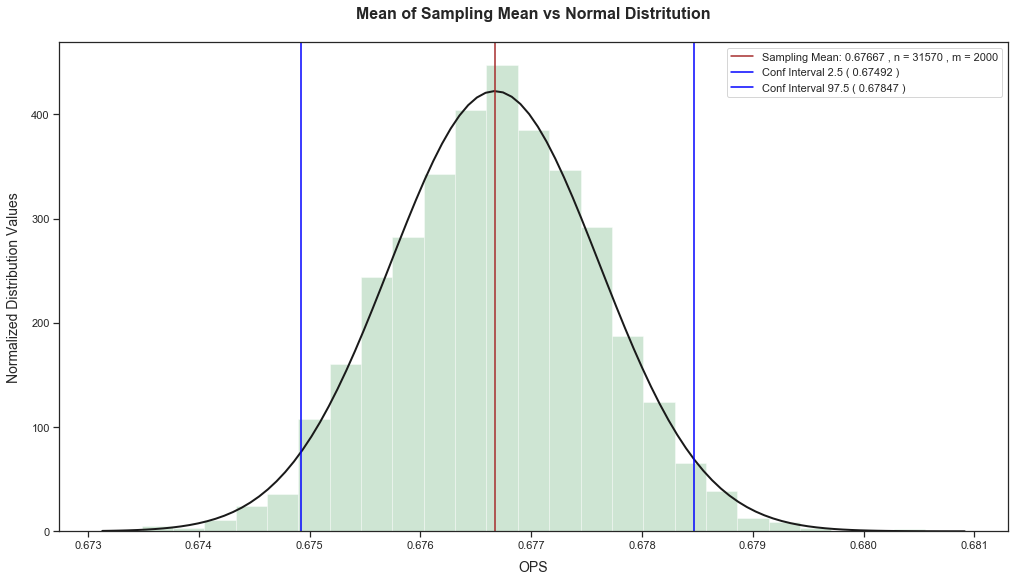

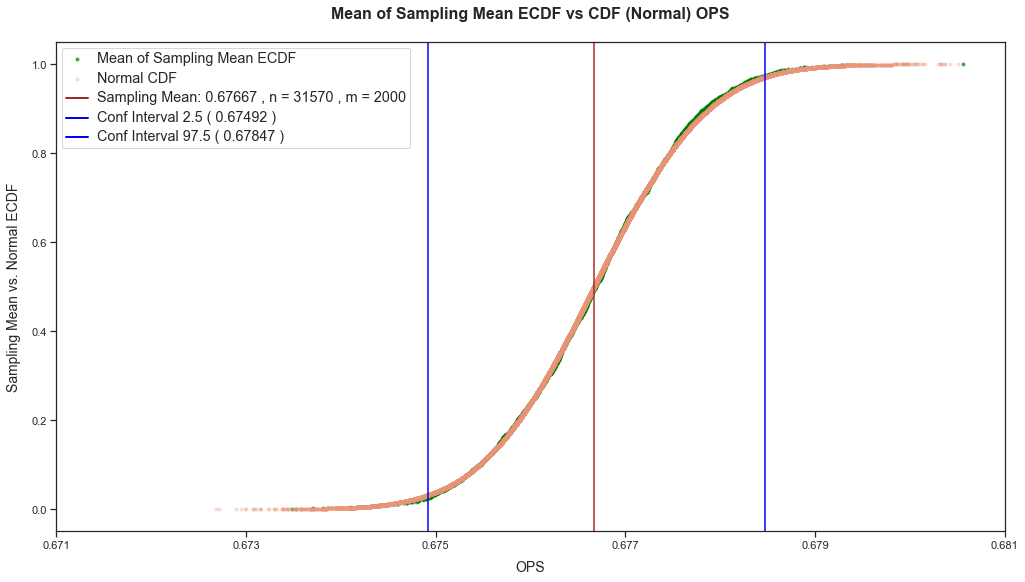

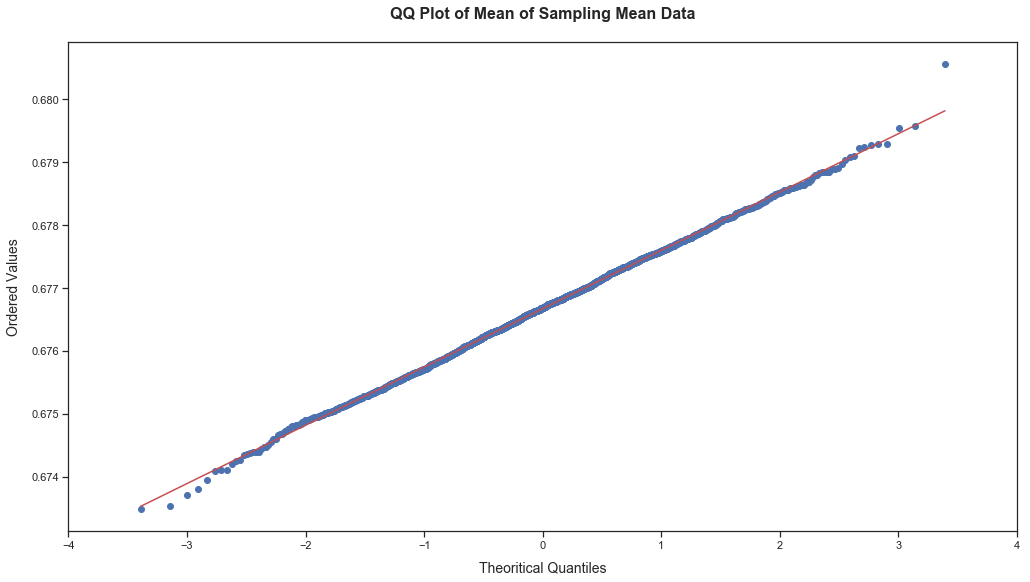




Two Tests for Null Hypothesis (H0) that Layman OPS Mean of Sample Means is Normal


DAgostinos K^2 Test:

Statistics=0.187, p=0.911
Data looks normal (fail to reject H0)


Anderson Darling Test:

Statistic: 0.296
15.000: 0.575, Data looks normal (fail to reject H0)
10.000: 0.655, Data looks normal (fail to reject H0)
5.000: 0.785, Data looks normal (fail to reject H0)
2.500: 0.916, Data looks normal (fail to reject H0)
1.000: 1.090, Data looks normal (fail to reject H0)





In [23]:
#
######################################################################################
#
# simulate muliple samples of OPS data using 1954 to 2017 data as sampling source
#
######################################################################################
#
data = df[(df['OPS'] <= 1.5) & (df['OPS'] > 0.0)]
data = np.array(data.OPS)
seed(61)
n=len(data)

m=2000

sqrtn = np.sqrt(n)
meanarr = np.array([np.mean(OPS_samples(data)) for i in range(m)])
conf_int = np.percentile(meanarr, [2.5, 97.5])
_ = plt.hist(meanarr, bins=25, alpha=0.4, density=True, color='#86bf91')
samplingmean = np.mean(meanarr)
samplingsigma = sigma/sqrtn
xmin, xmax = plt.xlim()
x = np.linspace(xmin, xmax, 100)
y = norm.pdf(x, samplingmean, samplingsigma)
plt.plot(x, y, 'k', linewidth=2)
_ = plt.title('Mean of Sampling Mean vs Normal Distritution\n',weight='bold', size=16)
_ = plt.xlabel('OPS', labelpad=10, size=14)
_ = plt.ylabel('Normalized Distribution Values', labelpad=10, size = 14)
lab = 'Sampling Mean: %1.5f' % samplingmean + ' , n = ' + str(n) + ' , m = ' + str(m)
lab1 = 'Conf Interval 2.5 ( %1.5f' % conf_int[0] + ' )'
lab2 = 'Conf Interval 97.5 ( %1.5f' % conf_int[1] + ' )'
plb.axvline(samplingmean,label=lab, color='brown')
plb.axvline(conf_int[0], label=lab1, color='blue')
plb.axvline(conf_int[1], label=lab2, color='blue')
leg = plt.legend()
plt.show()

# ECDF and norm CDF
x_ops, y_ops = ecdf(meanarr)
sample = np.random.normal(samplingmean, samplingsigma, size=100000)
x_n, y_n = ecdf(sample)
_ = plt.plot(x_ops,y_ops,marker='.',linestyle='none',color='green',alpha=.6, label='Mean of Sampling Mean ECDF')
_ = plt.plot(x_n, y_n, marker='.',linestyle='none', label = 'Normal CDF',color='darksalmon',alpha=.25)
_ = plt.title('Mean of Sampling Mean ECDF vs CDF (Normal) OPS\n',weight='bold', size=16)
_ = plt.xlabel('OPS', labelpad=10, size=14)
_ = plt.ylabel('Sampling Mean vs. Normal ECDF', labelpad=10, size = 14)
lab = 'Sampling Mean: %1.5f' % samplingmean + ' , n = ' + str(n) + ' , m = ' + str(m)
lab1 = 'Conf Interval 2.5 ( %1.5f' % conf_int[0] + ' )'
lab2 = 'Conf Interval 97.5 ( %1.5f' % conf_int[1] + ' )'
plb.axvline(samplingmean,label=lab, color='brown')
plb.axvline(conf_int[0],label=lab1, color='blue')
plb.axvline(conf_int[1],label=lab2, color='blue')
leg = plt.legend()
plt.xticks(np.arange(.671,.682,.002))
ax = plt.gca()
ax.xaxis.set_major_formatter(mtick.StrMethodFormatter('{x:1.3f}'))
# get the individual lines inside legend and set line width
for line in leg.get_lines():
    line.set_linewidth(2)
# get label texts inside legend and set font size
for text in leg.get_texts():
    text.set_fontsize('large')
plt.show()
# plot mean of means normal dist
probplot(meanarr,dist="norm",plot=plb)
_ = plt.title('QQ Plot of Mean of Sampling Mean Data\n',weight='bold', size=16)
_ = plt.ylabel('Ordered Values', labelpad=10, size=14)
_ = plt.xlabel('Theoritical Quantiles', labelpad=10, size = 14)
ax = plt.gca()
ax.yaxis.set_major_formatter(mtick.StrMethodFormatter('{x:1.3f}'))
plt.xticks(np.arange(-4,5,1))
plb.show()

# perform a number of tests on layman population OPS data
print('\n\n')
print('Two Tests for Null Hypothesis (H0) that Layman OPS Mean of Sample Means is Normal\n\n')
# D'Agostinos K^2 Test
stat, p = normaltest(meanarr)
print('D''Agostinos K^2 Test:\n')
print('Statistics=%.3f, p=%.3f' % (stat, p))
alpha = 0.05
if p < alpha:
    print("Data does not look normal (reject H0)")
else:
    print("Data looks normal (fail to reject H0)")
print('\n')
# Anderson Darling test
result = anderson(meanarr)
print('Anderson Darling Test:\n')
print('Statistic: %.3f' % result.statistic)
p = 0
for i in range(len(result.critical_values)):
	sl, cv = result.significance_level[i], result.critical_values[i]
	if result.statistic < result.critical_values[i]:
		print('%.3f: %.3f, Data looks normal (fail to reject H0)' % (sl, cv))
	else:
		print('%.3f: %.3f, Data does not look normal (reject H0)' % (sl, cv))
print('\n\n')

So, the sampling means appear to be normal.  I wondered if the calculated OPS for each sample would also be normally distributed repeated over and over again.  So, I ran multiple replicate samples with replacement against the collected data and calculated the "combined" OPS for each sample.  Each of the OPS values were saved and the distribution was charted.  The following is the plotted information.  

Note that the combined OPS is greater than the mean OPS.  This is because it is a weighted statistic.  The players that play more games are usually the better players and have more of a say in the OPS calculation (more at bats).  If you look on Baseball Reference or other sites, baseball statistics are shown not as a mean but as a calculated OPS value.  For example, yearly OPS values are calculated by taking the sum of the batting data and then the OPS calculation is made.  

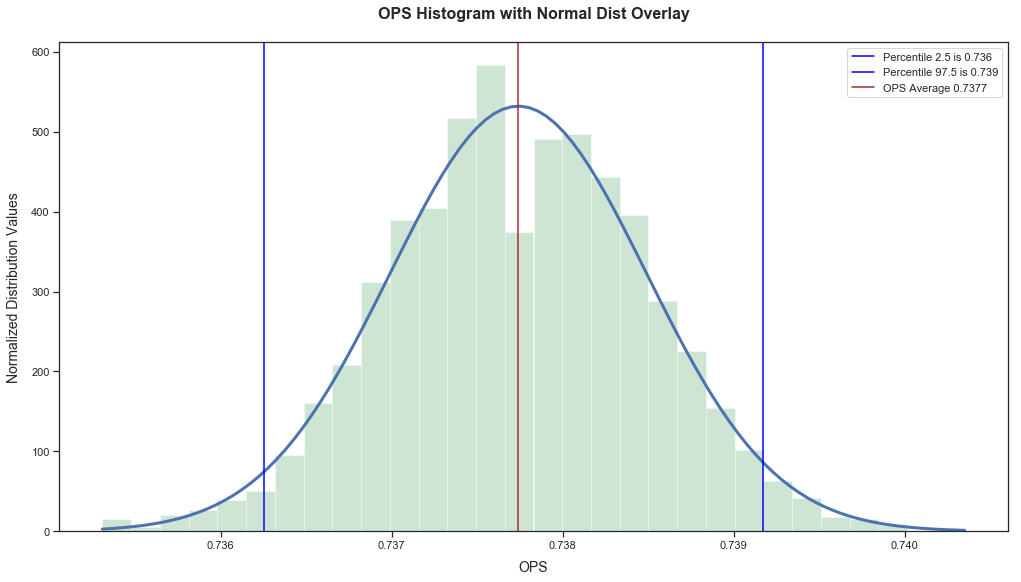

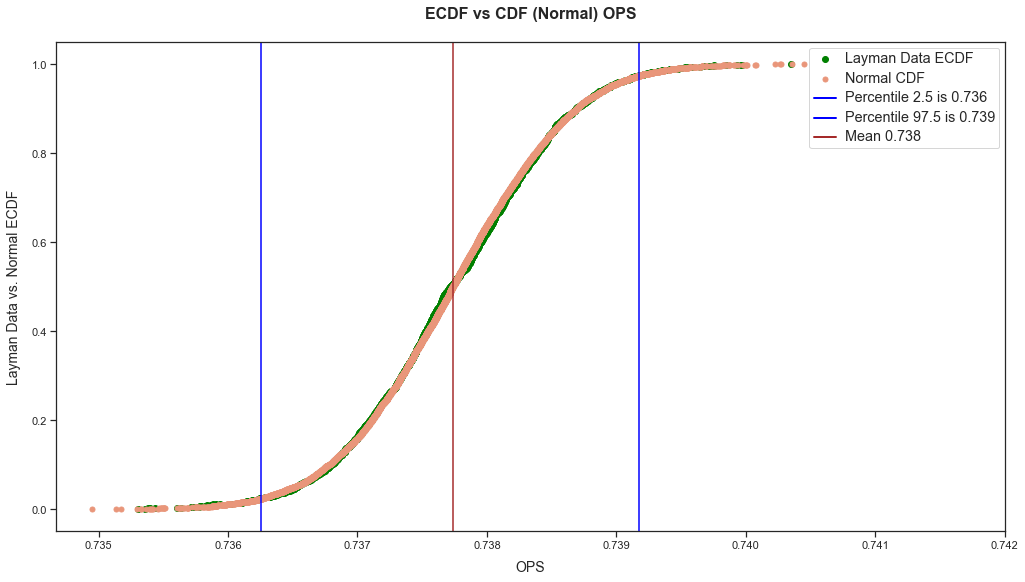

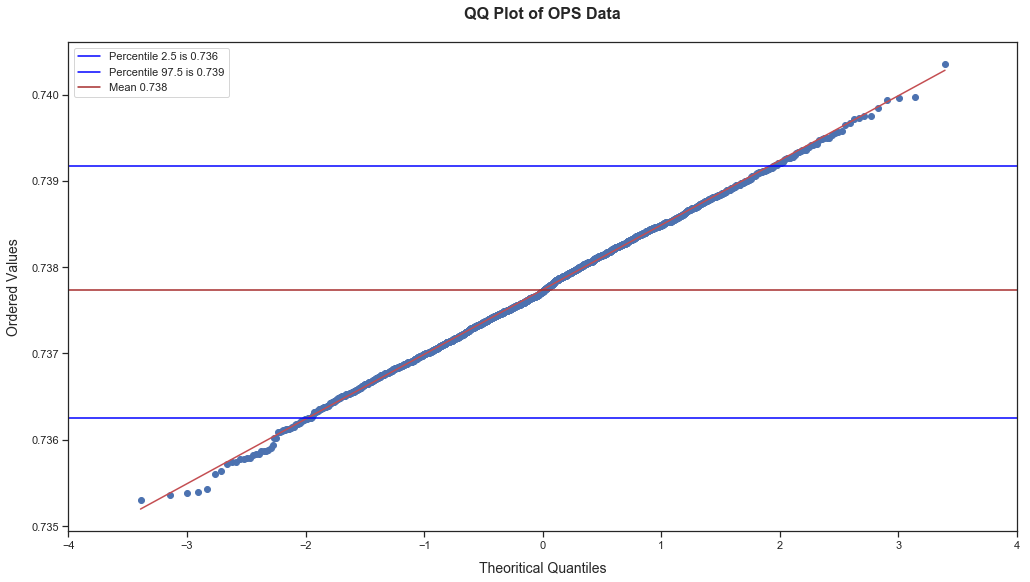




Two Tests for Null Hypothesis (H0) that Layman combined (calculated) OPS of Samples is Normal


DAgostinos K^2 Test:

Statistics=0.537, p=0.765
Data looks normal (fail to reject H0)


Anderson Darling Test:

Statistic: 0.596
15.000: 0.575, Data does not look normal (reject H0)
10.000: 0.655, Data looks normal (fail to reject H0)
5.000: 0.785, Data looks normal (fail to reject H0)
2.500: 0.916, Data looks normal (fail to reject H0)
1.000: 1.090, Data looks normal (fail to reject H0)





In [24]:
#
#############################################################################################################
#
#  calculate the combined OPS of sampling combined OPS's.  This also should be a normal dist.
#
#############################################################################################################
#
# use the same seed each time
seed(61)

m=2000

data = np.array([bootstrap_replicate_wr(df,OPS_val) for i in range(m)])
samplingmean = round(np.mean(data),5)
samplingsigma = round(np.std(data),5)
ptiles = [2.5, 97.5]
ptiles_vals = np.percentile(data,ptiles)
plt.hist(data, bins=30, alpha=0.4, density=True, color='#86bf91')
x = np.linspace(min(data), max(data), 100)
y = norm.pdf(x, samplingmean, samplingsigma)
plt.plot(x, y, linewidth = 3)
plt.title('OPS Histogram with Normal Dist Overlay\n',weight='bold', size=16)
plt.xlabel('OPS', labelpad=10, size=14)
plt.ylabel('Normalized Distribution Values', labelpad=10, size = 14)
label0 = 'Percentile 2.5 is %1.3f' % ptiles_vals[0]
label1 = 'Percentile 97.5 is %1.3f' % ptiles_vals[1]
labelm = 'OPS Average %1.4f' % samplingmean
#labelst = 'OPS Steroid Era (1993 to 2003) %1.3f' % OPSsteroid
#labelps = 'OPS Post Sterioid (2004 to 2014) %1.3f' % OPSpost
plb.axvline(ptiles_vals[0],label=label0, color='blue')
plb.axvline(ptiles_vals[1],label=label1, color='blue')
#plb.axvline(OPSsteroid,label=labelst, color='red')
#plb.axvline(OPSpost,label=labelps, color='black')
plb.axvline(samplingmean,label=labelm, color='brown')
leg = plt.legend()
plt.show()

x_ops, y_ops = ecdf(data)
sample = np.random.normal(samplingmean, samplingsigma, size=10000)
ptiles = [2.5, 97.5]
ptiles_vals = np.percentile(x_ops,ptiles)
x_n, y_n = ecdf(sample)
plt.plot(x_ops,y_ops,marker='.',linestyle='none',color='green', markersize = 12,label='Layman Data ECDF')
plt.plot(x_n, y_n, marker='.',linestyle='none',color='darksalmon', markersize = 10, label = 'Normal CDF')
plt.title('ECDF vs CDF (Normal) OPS\n',weight='bold', size=16)
plt.xlabel('OPS', labelpad=10, size=14)
plt.ylabel('Layman Data vs. Normal ECDF', labelpad=10, size = 14)
label0 = 'Percentile 2.5 is %1.3f' % ptiles_vals[0]
label1 = 'Percentile 97.5 is %1.3f' % ptiles_vals[1]
labelm = 'Mean %1.3f' % samplingmean
plb.axvline(ptiles_vals[0],label=label0, color='blue')
plb.axvline(ptiles_vals[1],label=label1, color='blue')
plb.axvline(samplingmean,label=labelm, color='brown')
plt.xticks(np.arange(.735,.742,.001))
ax = plt.gca()
ax.xaxis.set_major_formatter(mtick.StrMethodFormatter('{x:1.3f}'))
leg = plt.legend()
# get the individual lines inside legend and set line width
for line in leg.get_lines():
    line.set_linewidth(2)
# get label texts inside legend and set font size
for text in leg.get_texts():
    text.set_fontsize('large')
plt.show()

# plot QQ Plot to see if normal
probplot(data,dist="norm",plot=plb)
plt.title('QQ Plot of OPS Data\n',weight='bold', size=16)
plt.ylabel('Ordered Values', labelpad=10, size=14)
plt.xlabel('Theoritical Quantiles', labelpad=10, size = 14)
ax = plt.gca()
label0 = 'Percentile 2.5 is %1.3f' % ptiles_vals[0]
label1 = 'Percentile 97.5 is %1.3f' % ptiles_vals[1]
labelm = 'Mean %1.3f' % samplingmean
plb.axhline(ptiles_vals[0],label=label0, color='blue')
plb.axhline(ptiles_vals[1],label=label1, color='blue')
plb.axhline(samplingmean,label=labelm, color='brown')
leg = plt.legend()
ax.yaxis.set_major_formatter(mtick.StrMethodFormatter('{x:1.3f}'))
plt.xticks(np.arange(-4,5,1))
plt.show()

# perform a number of tests on layman population OPS data
meanarr = data
print('\n\n')
print('Two Tests for Null Hypothesis (H0) that Layman combined (calculated) OPS of Samples is Normal\n\n')
# D'Agostinos K^2 Test
stat, p = normaltest(meanarr)
print('D''Agostinos K^2 Test:\n')
print('Statistics=%.3f, p=%.3f' % (stat, p))
alpha = 0.05
if p < alpha:
    print("Data does not look normal (reject H0)")
else:
    print("Data looks normal (fail to reject H0)")
print('\n')
# Anderson Darling test
result = anderson(meanarr)
print('Anderson Darling Test:\n')
print('Statistic: %.3f' % result.statistic)
p = 0
for i in range(len(result.critical_values)):
	sl, cv = result.significance_level[i], result.critical_values[i]
	if result.statistic < result.critical_values[i]:
		print('%.3f: %.3f, Data looks normal (fail to reject H0)' % (sl, cv))
	else:
		print('%.3f: %.3f, Data does not look normal (reject H0)' % (sl, cv))
print('\n\n')

Note there is subtest in the Anderson Darling tests that rejects the Null Hypothesis.  The rest of the tests conclude it is normally distributed.  This information could be valuable in determining confidence intervals using the calculated OPS vs mean OPS.  Test are tools just as visualizations are.  Histograms can represent data in different forms depending upon the number of bins.  The CDF and QQ plots better show that this looks to be normally distributed.

Observed in the data discovery notebook was that of the superstars charted,  the minimum years played once their contract was satisfied was 12 years. So, I looked at all position players since 1954 who have played at least 12 years in major league baseball. I charted scatter plots of these players broken into two plots, the first plot showing all position players playing 12 years or more with a average OPS of .8334 or higher.  The second plot showed all position players playing 12 years or more with an anverage OPS of between .7667 and .8333.   What I am looking for is career trends for high performing players for perdictive purposes.  

The final plot charts number of years played and their calculated OPS.  It clearly shows that players who tend to play longer have better OPS performance statistics which makes sense. 

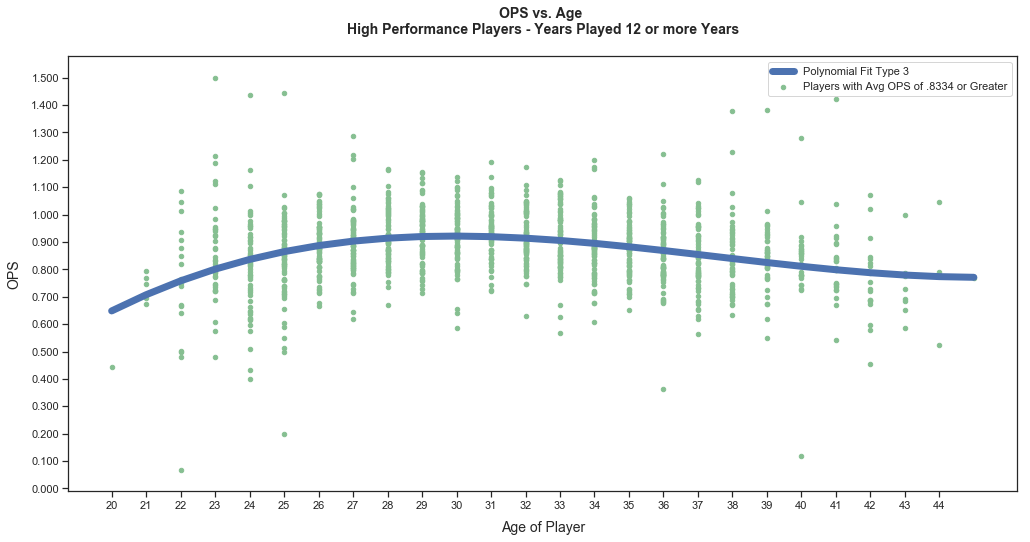

Pearson Correlation -0.059


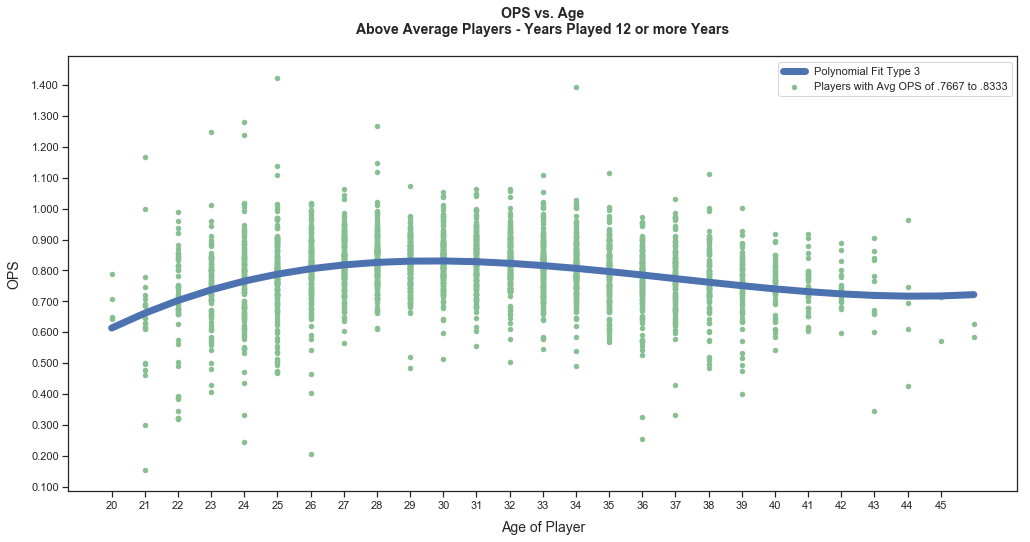

Pearson Correlation -0.023


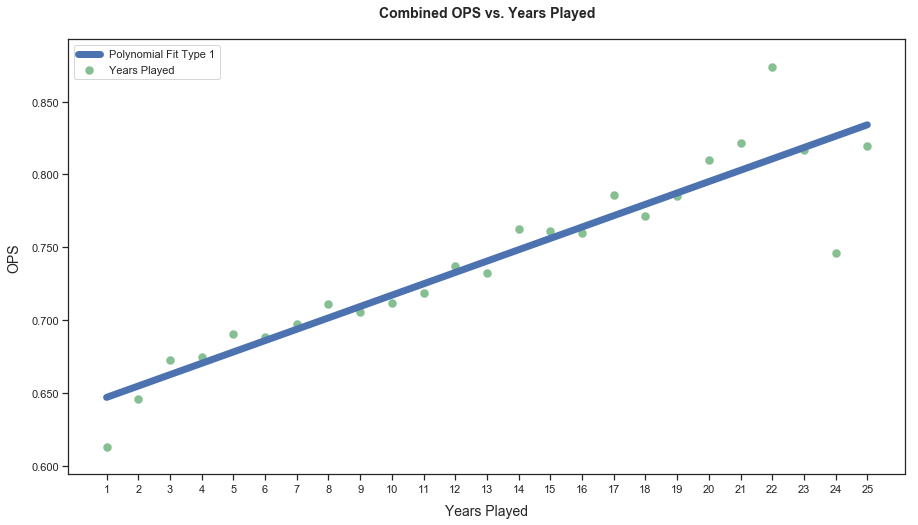

Pearson Correlation 0.924


In [25]:
#
#############################################################################################################
#
#  scatter plots for various cross sections of data looking for a good Pearson Correlation
#
#############################################################################################################
#
# Scatter plot for players playing for 12 or more years by OPS vs Age (.8334 AVG OPS or greater)
#
dfplot = df[ (df['OPS_AVG'] >= .8334) & (df['years_played'] >= 12) & (df['OPS'] <= 1.5) & (df['age'] >= 20)][['OPS','age']]
dfplot.age = dfplot.age.round()
ax = dfplot.plot(kind='scatter',x='age',y='OPS',color='#86bf91', figsize=(FSHZ,8),label='Players with Avg OPS of .8334 or Greater')
ax.set_title('OPS vs. Age \nHigh Performance Players - Years Played 12 or more Years\n', weight='bold', size=14)
ax.set_xlabel("Age of Player", labelpad=10, size=14)
ax.set_ylabel("OPS", labelpad=10, size=14)
for tick in ax.get_xticklabels():
    tick.set_fontsize(11)
for tick in ax.get_yticklabels():
    tick.set_fontsize(11)
sage = np.array(dfplot.age)
sops = np.array(dfplot.OPS)
plt.yticks(np.arange(0,1.6,.1))
plt.xticks(np.arange(min(sage),max(sage),1))
ax.yaxis.set_major_formatter(mtick.StrMethodFormatter('{x:1.3f}'))
type = 3
coef,x,y = calc_poly(sage,sops,type)
#dfxy = pd.DataFrame(xs,ys)
plt.plot(x,y,label= 'Polynomial Fit Type %1.f' % type, linewidth=7)
leg = plt.legend()
plt.show()

cov = myCovariance(sage,sops)
pcorr = myPearson_Corr(cov, sage, sops)
print('Pearson Correlation %.3f' % pcorr)

# Scatter plot for players playing for 12 or more years by OPS vs Age 
dfplot = df[ (df['OPS_AVG'] >= .7667) & (df['OPS_AVG'] <= .8333) & (df['years_played'] >= 12) & (df['OPS'] <= 1.5) & (df['age'] >= 20)][['OPS','age']]
dfplot.age = dfplot.age.round()
ax = dfplot.plot(kind='scatter',x='age',y='OPS',color='#86bf91', figsize=(FSHZ,8), label='Players with Avg OPS of .7667 to .8333')
ax.set_title('OPS vs. Age\nAbove Average Players - Years Played 12 or more Years\n', weight='bold', size=14)
ax.set_xlabel("Age of Player", labelpad=10, size=14)
ax.set_ylabel("OPS", labelpad=10, size=14)
for tick in ax.get_xticklabels():
    tick.set_fontsize(11)
for tick in ax.get_yticklabels():
    tick.set_fontsize(11)
sage = np.array(dfplot.age)
sops = np.array(dfplot.OPS)
plt.yticks(np.arange(0,1.6,.1))
plt.xticks(np.arange(min(sage),max(sage),1))
ax.yaxis.set_major_formatter(mtick.StrMethodFormatter('{x:1.3f}'))
type = 3
coef,x,y = calc_poly(sage,sops,type)
#dfxy = pd.DataFrame(xs,ys)
plt.plot(x,y,label= 'Polynomial Fit Type %1.f' % type, linewidth=7)
leg = plt.legend()
plt.show()

cov = myCovariance(sage,sops)
pcorr = myPearson_Corr(cov, sage, sops)
print('Pearson Correlation %.3f' % pcorr)

#
#  plot years played against OPS with polynomial
#
dfplot = df[(df['OPS'] <= 1.5)][['years_played','POS','H','BB','HBP','AB','SF','1B','2B','3B','HR']]
dfplot = dfplot.groupby(['years_played']).sum()
dfplot = dfplot.reset_index()
dfplot = calc_ops(dfplot)
dfplot = dfplot.reset_index()
ax = dfplot.plot(kind='scatter',x='years_played',y='OPS',figsize=(15,8),linewidth=4,color='#86bf91', label='Years Played')
ax.set_title('Combined OPS vs. Years Played\n',weight='bold', size=14)
ax.set_xlabel("Years Played", labelpad=10, size=14)
ax.set_ylabel("OPS", labelpad=10, size=14)
ax.yaxis.set_major_formatter(mtick.StrMethodFormatter('{x:1.3f}'))
syp = np.array(dfplot.years_played)
sops = np.array(dfplot.OPS)
plt.yticks(np.arange(.200,1.500,.050))
plt.xticks(np.arange(min(syp), max(syp) + 1,1))
type = 1
coef,x,y = calc_poly(syp,sops,type)
ax = plt.plot(x,y,label= 'Polynomial Fit Type %1.f' % type, linewidth=7)
leg = plt.legend()
plt.show()
cov = myCovariance(syp,sops)
pcorr = myPearson_Corr(cov, syp, sops)
print('Pearson Correlation %.3f' % pcorr)

The above first two plots show poor linear coorelation, but using polynomial fitting, the resulting polynomials seems to fit the data.  I used degree 3 polynomials  The last plot shows a linear regression model. 

The next set of tests looks at the steroid era and whether or not it "sticks out" from other eras.  Two bootstrap sets of tests, two sample tests and permutation tests were run.  Baseball statistics data is segmented into three segments...pre steroid era, steriod era and post steroid era.  Pre steroid era was defined from 1982 to 1992.  The steroid era was defined to be from 1993 to 2003, and the post steroid era was defined to be from 2004 to 2014.  There is no exact timeline definition for the steroid era, and ESPN defines it as being from late 1980's to late 2000's and others define it differently.  The first two sample test tests the null hypothesis that the means of the two samples are identical.  That is the pre steroid era mean is the same as the steroid era mean which implies there was no performance gain.  The second two sample test looks at the steroid era and post steroid era and tests the null hypothesis that the two sample means are the same.  A two sample test was performed with pre steroid era and the post steroid era sample to test that the means are the same.

Here are the results of the three two sample tests.

In [26]:
import warnings; warnings.simplefilter('ignore')
#
####################################################################################################
#
# Perform two sample and permutation tests
#
###################################################################################################

m = 5000

dfpre = df[ (df['yearID'] >= 1982) & (df['yearID'] <= 1992) ]
dfst = df[ (df['yearID'] >= 1993) & (df['yearID'] <= 2003) ]
dfpost = df[ (df['yearID'] >= 2004) & (df['yearID'] <= 2014) ]

dfpre_OPS = calc_ops(dfpre)
dfst_OPS  = calc_ops(dfst)
dfpost_OPS = calc_ops(dfpost)

prearr = dfpre_OPS.OPS
starr = dfst_OPS.OPS
postarr = dfpost_OPS.OPS

OPS_pre = OPS_val(dfpre)
OPS_st = OPS_val(dfst)
OPS_post = OPS_val(dfpost)

meanpre = np.mean(prearr)
meanpost = np.mean(postarr)
meanst = np.mean(starr)

#
##################################################################################################
#
#  two sample test pre steroid to steroid era 
#
##################################################################################################
#

mean_diff = meanst - meanpre

botharr = pd.concat([prearr,starr])
mean_both = np.mean(botharr)

prearr_shifted = prearr - meanpre + mean_both
starr_shifted  = starr  - meanst + mean_both

bs_prearr = choice_replicates(prearr_shifted,np.mean,m)
bs_starr = choice_replicates(starr_shifted,np.mean,m)

bs_replicates = bs_starr - bs_prearr
p = np.sum(bs_replicates >= mean_diff) / len(bs_replicates)

print('Empirical Diff of Pre Era and Steroid Era OPS = %1.6f' % mean_diff)
print('\n')
print('Min and Max Two Sample Replicates Diff = %1.3f' % min(bs_replicates) + ', %1.3f' % max(bs_replicates))
print('\n')
print('p-value = %1.5f' %p)
print('\n')

#
##################################################################################################
#
#  two sample test post steroid to steroid era 
#
##################################################################################################
#

mean_diff = meanst - meanpost

botharr = pd.concat([postarr,starr])
mean_both = np.mean(botharr)

postarr_shifted = postarr - meanpost + mean_both
starr_shifted  = starr  - meanst + mean_both

bs_postarr = choice_replicates(postarr_shifted,np.mean,m)
bs_starr = choice_replicates(starr_shifted,np.mean,m)

bs_replicates = bs_starr - bs_postarr
p = np.sum(bs_replicates >= mean_diff) / len(bs_replicates)

print('Empirical Diff of Post Era and Steroid Era OPS = %1.6f' % mean_diff)
print('\n')
print('Min and Max Two Sample Replicates Diff = %1.3f' % min(bs_replicates) + ', %1.3f' % max(bs_replicates))
print('\n')
print('p-value = %1.5f' %p)
print('\n')

#
##################################################################################################
#
#  two sample test post steroid to pre steroid era.
#
##################################################################################################
#

mean_diff = meanpost - meanpre

botharr = pd.concat([postarr,prearr])
mean_both = np.mean(botharr)

postarr_shifted = postarr - meanpost + mean_both
prearr_shifted  = prearr  - meanpre + mean_both

bs_postarr = choice_replicates(postarr_shifted,np.mean,m)
bs_prearr = choice_replicates(prearr_shifted,np.mean,m)

bs_replicates = bs_postarr - bs_prearr
p = np.sum(bs_replicates >= mean_diff) / len(bs_replicates)

print('Empirical Diff of Post Era and Pre Era OPS = %1.6f' % mean_diff)
print('\n')
print('Min and Max Two Sample Replicates Diff = %1.3f' % min(bs_replicates) + ', %1.3f' % max(bs_replicates))
print('\n')
print('p-value = %1.5f' %p)
print('\n')

Empirical Diff of Pre Era and Steroid Era OPS = 0.046502


Min and Max Two Sample Replicates Diff = -0.011, 0.011


p-value = 0.00000


Empirical Diff of Post Era and Steroid Era OPS = 0.019940


Min and Max Two Sample Replicates Diff = -0.011, 0.011


p-value = 0.00000


Empirical Diff of Post Era and Pre Era OPS = 0.026562


Min and Max Two Sample Replicates Diff = -0.011, 0.011


p-value = 0.00000




This is an interesting set of results.  It shows that the pre and post era data as compared to the steroid era have different means but so do two sample tests with pre and post era data.  The results of the tests don't seem conclusive.  Also permutation tests were run to see if the distributions were the same.  The null hpothesis was that the difference of the means was 0.  Below is the results of two permutations tests.  One run with steroid era and post steroid era data.  The second test is with pre and post steroid era data.  Note the results are the same.  The data seems to vary greatly between all eras.

In [27]:
#
##################################################################################################
#
#  Permutation Test (OPS) of 2004 to 2014 (post steroid) and 1993 to 2003 (steroid era)
#
##################################################################################################
#

mean_diff = meanst - meanpost

OPSarr_st_permr, OPSarr_post_permr, OPSarr_diff = perm_replicates_mean(postarr, starr, m)

#calculate the p-value
p = np.sum(OPSarr_diff >= mean_diff) / len(OPSarr_diff)

print('Empirical Diff of Steroid Era OPS and Post Era OPS = %1.3f' % mean_diff)
print('\n')
print('Min and Max Permutation Replicates Diff = %1.3f' % min(OPSarr_diff) + ', %1.3f' % max(OPSarr_diff))
print('\n')
print('p-value = %1.3f' %p)
print('\n')

#
##################################################################################################
#
#  Permutation Test (OPS) of 1982 to 1992 (pre steroid) and 2004 to 2014 (post era)
#
##################################################################################################
#

mean_diff = meanpost - meanpre

OPSarr_pre_permr, OPSarr_post_permr, OPSarr_diff = perm_replicates_mean(prearr, postarr, m)

#calculate the p-value
p = np.sum(OPSarr_diff >= mean_diff) / len(OPSarr_diff)

print('Empirical Diff of Pre Era OPS and Post Era OPS = %1.3f' % mean_diff)
print('\n')
print('Min and Max Permutation Replicates Diff = %1.3f' % min(OPSarr_diff) + ', %1.3f' % max(OPSarr_diff))
print('\n')
print('p-value = %1.3f' %p)
print('\n')

Empirical Diff of Steroid Era OPS and Post Era OPS = 0.020


Min and Max Permutation Replicates Diff = -0.011, 0.010


p-value = 0.000


Empirical Diff of Pre Era OPS and Post Era OPS = 0.027


Min and Max Permutation Replicates Diff = -0.010, 0.011


p-value = 0.000




A closer look at the data reveals some interesting results.   Below is a set of CDF plots from 1972 to 2014 of the OPS data.  Replicates were used to create distributions of calculated OPS (combined OPS) sets of data and were plotted together on one plot.  Here are the results.

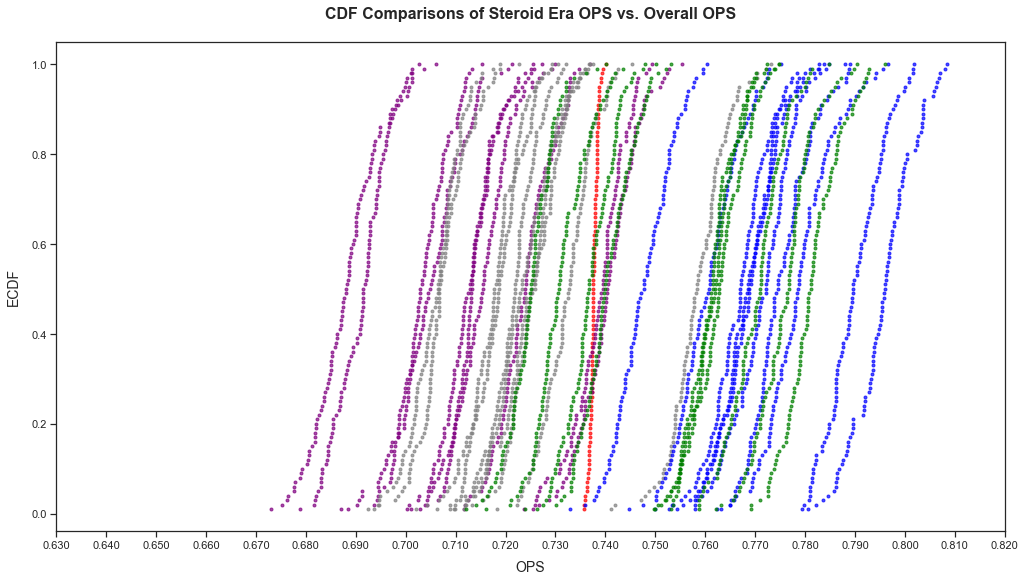

In [28]:
#
###################################################################################################
# 
# Time Series Analysis
#
###################################################################################################
# 
m=100
ecdf_plot_replicates(df,m,'red')
for year in range(1971,1981,1):
    dfyr = df[df['yearID'] == year]
    dfyr = dfyr.reset_index(drop=True)
    ecdf_plot_replicates(dfyr,m,'purple')
for year in range(1982,1992,1):
    dfyr = df[df['yearID'] == year]
    dfyr = dfyr.reset_index(drop=True)
    ecdf_plot_replicates(dfyr,m,'grey')
for year in range(1993,2003,1):
    dfyr = df[df['yearID'] == year]
    dfyr = dfyr.reset_index(drop=True)
    ecdf_plot_replicates(dfyr,m,'blue')
for year in range(2004,2014,1):
    dfyr = df[df['yearID'] == year]
    dfyr = dfyr.reset_index(drop=True)
    ecdf_plot_replicates(dfyr,m,'green')
plt.title('CDF Comparisons of Steroid Era OPS vs. Overall OPS\n',weight='bold', size=16)
plt.xlabel('OPS', labelpad=10, size=14)
plt.ylabel('ECDF', labelpad=10, size = 14)
plt.xticks(np.arange(.630,.83,.01))
ax = plt.gca()
ax.xaxis.set_major_formatter(mtick.StrMethodFormatter('{x:1.3f}'))
# get the individual lines inside legend and set line width
for line in leg.get_lines():
    line.set_linewidth(2)
# get label texts inside legend and set font size
for text in leg.get_texts():
    text.set_fontsize('large')
plt.show()

Wow!  It looks like the replicate CDF's show that the distributions by calculating OPS replicates for each year from 1971 to 2014 vary greatly with different average OPS distributions.  So, rushing to judgement would not be a good idea.  You can see that the blue CDF's (steroid era) tend to be on the higher end of the average OPS's charted.  But it could just be part of the overall trend picture.

Purple - Distributions from 1971 to 1981 (another pre steroid era)

Grey - Distributions from 1982 to 1992 (pre steroid era)

Blue - Distributions from 1993 to 2003 (steroid era)

Green - Distributions from 2004 to 2014 (post steroid era)

It looks like some time series analysis is needed.  

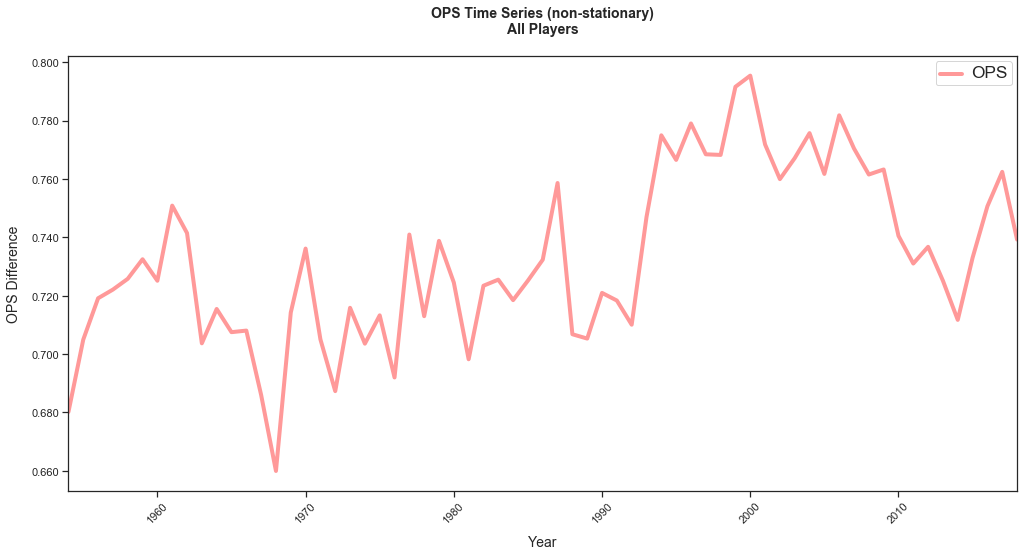



significance level = 0.05


OPS adfuller result: 0.322
accept H0: presence of a unit root (not stationary)


In [29]:
#
# set up dfplot data frame for time series analysis
#
dfplot = df[['yearID','H','BB','HBP','AB','SF','1B','2B','3B','HR']]
dfplot = dfplot.groupby(['yearID']).sum()
dfplot = calc_ops(dfplot)
dfplot = dfplot[['OPS']]
dfplot = dfplot.reset_index()

diffops = dfplot.OPS.diff()
diffops = diffops.dropna()
diffops = diffops.reset_index()
diffops.columns = ['yearID','OPSdiff']
diffops.yearID = diffops.yearID + 1953

#
# OPS Times Series plot non-stationary
#

ax = dfplot.plot(kind='line',x='yearID',figsize=(FSHZ,8),linewidth=4,color=['#ff9999','#66b3ff','#99ff99'])
ax.set_title('OPS Time Series (non-stationary)\nAll Players\n',weight='bold', size=14)
ax.set_xlabel("Year", labelpad=10, size=14)
ax.set_ylabel("OPS Difference", labelpad=10, size=14)
leg = plt.legend()
# get the individual lines inside legend and set line width
for line in leg.get_lines():
    line.set_linewidth(4)
# get label texts inside legend and set font size
for text in leg.get_texts():
    text.set_fontsize('x-large')
#plt.yticks(np.arange())
ax.yaxis.set_major_formatter(mtick.StrMethodFormatter('{x:1.3f}'))
plt.xticks(rotation=45)
plt.show()

# adfuller test on OPS time series
significance = 0.05
print('\n')
print('significance level = %1.2f' % significance)
result = adfuller(dfplot.OPS)
print('\n')
print('OPS adfuller result: %1.3f' % result[1])
if result[1] >= significance:
    print('accept H0: presence of a unit root (not stationary)')
else:
    print('reject H0: no presence of a unit root (stationary)')


After plotting the OPS statistics by year from 1954 to 2018, the adfuller test shows that the time series is not stationary.  It seems to be gradually growing in a positive direction.

The next plot shows the growth a bit more clearly.

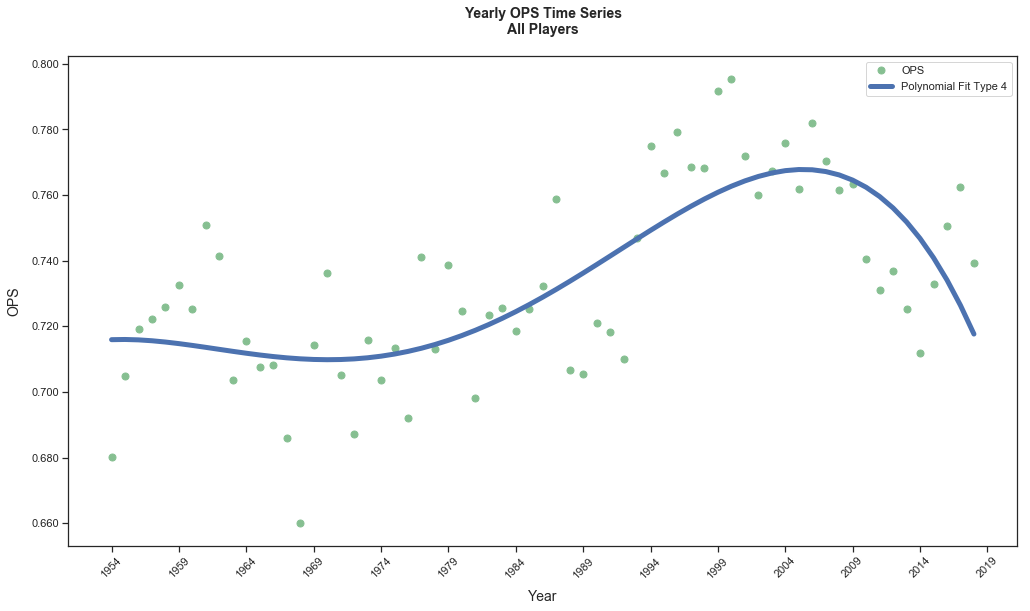

In [30]:
#
# plot players by year against OPS for all players
# fitting polynomial curve
#
dfplot = df[['yearID','H','BB','HBP','AB','SF','1B','2B','3B','HR']]
dfplot = dfplot.groupby(['yearID']).sum()
dfplot = calc_ops(dfplot)
dfplot = dfplot[['OPS']]
dfplot = dfplot.reset_index()
syr = np.array(dfplot.yearID)
sops = np.array(dfplot.OPS)
fig, ax = plt.subplots()
ax.set_title('Yearly OPS Time Series\nAll Players\n',weight='bold', size=14)
ax.set_xlabel("Year", labelpad=10, size=14)
ax.set_ylabel("OPS", labelpad=10, size=14)
ax.plot(dfplot.yearID, dfplot['OPS'], marker='.', linestyle='none',markersize=14,color='#86bf91')
plt.yticks(np.arange(.400,.900,.020))
plt.xticks(np.arange(min(syr),max(syr)+5,5))
#ax = dfplot.plot(kind='line',x='yearID',figsize=(FSHZ,8),linewidth=4,color=['#ff9999','#66b3ff','#99ff99'])
type = 4
coef,x,y = calc_poly(syr,sops,type)
plt.plot(x,y,label= 'Polynomial Fit Type %1.f' % type, linewidth=5)
ax.yaxis.set_major_formatter(mtick.StrMethodFormatter('{x:1.3f}'))
plt.xticks(rotation=45)
leg = plt.legend()
plt.show()

The upward trend appears to have started in the early 1970's and has trended upwards until about the mid to late 2000's.  Before any time series analysis can be performed, the time series needs to be stationary.  To achieve this, the the differnces were taken with lag of the OPS data and the results are as follows:  

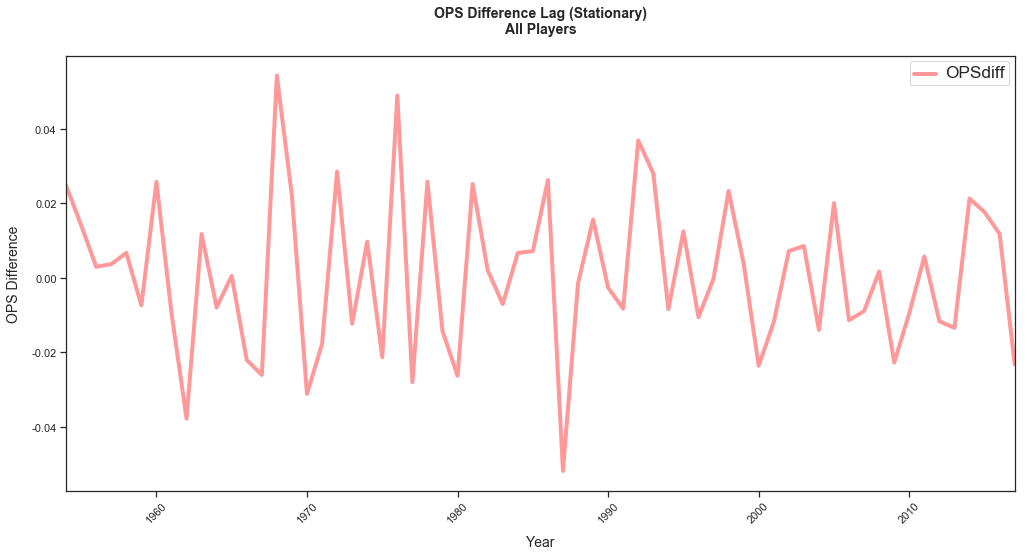



OPS Pct Change adfuller result: 0.000000000000621
reject H0: no presence of a unit root (stationary)




In [31]:
#
# plot difference in one lag OPS data to make it stationary.
#
ax = diffops.plot(kind='line',x='yearID',figsize=(FSHZ,8),linewidth=4,color=['#ff9999','#66b3ff','#99ff99'])
ax.set_title('OPS Difference Lag (Stationary)\nAll Players\n',weight='bold', size=14)
ax.set_xlabel("Year", labelpad=10, size=14)
ax.set_ylabel("OPS Difference", labelpad=10, size=14)
leg = plt.legend()
# get the individual lines inside legend and set line width
for line in leg.get_lines():
    line.set_linewidth(4)
# get label texts inside legend and set font size
for text in leg.get_texts():
    text.set_fontsize('x-large')
ax.yaxis.set_major_formatter(mtick.StrMethodFormatter('{x:1.2f}'))
#plt.yticks(np.arange())
plt.xticks(rotation=45)
plt.show()

# adfuller test for stationary time series (diff)
print('\n')
result = adfuller(diffops.OPSdiff)
print('OPS Pct Change adfuller result: %1.15f' % result[1])
if result[1] >= significance:
    print('accept H0: presence of a unit root (not stationary)')
else:
    print('reject H0: no presence of a unit root (stationary)')
print('\n')

Now the time series appears to be stationary.  More to come on this.

The final two plots uses two anomoly detection algorithms to show potential anomolies to be assessed.  Once you see the plots you will understand that this was fairly academic in this case for this data. 

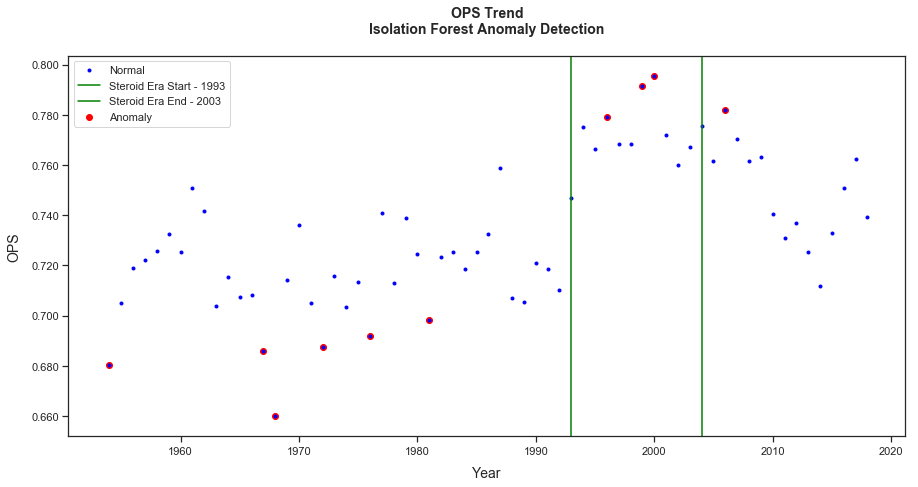

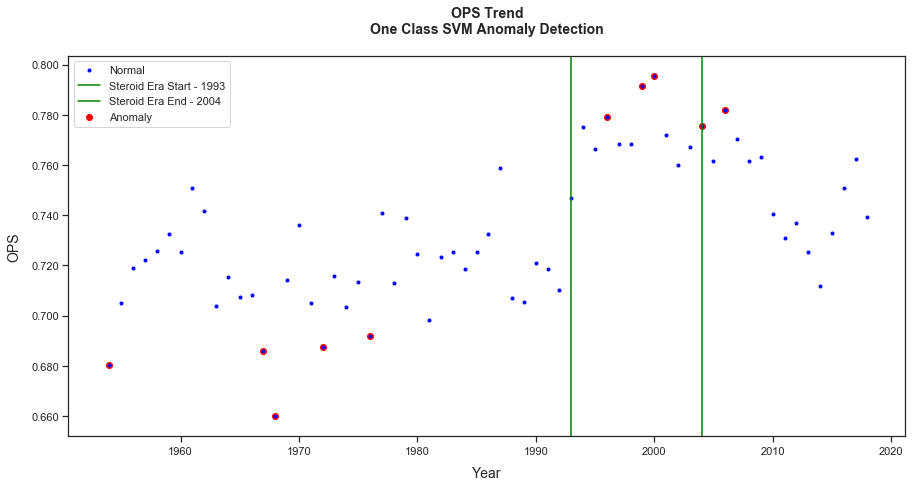

In [32]:
#
# isolation forest for anomaly detection
#
dfx = dfplot[['OPS','yearID']]
data = dfplot[['OPS']]
scaler = StandardScaler()
np_scaled = scaler.fit_transform(data)
data = pd.DataFrame(np_scaled)
# train isolation forest
model =  IsolationForest(contamination=0.15)
model.fit(data) 
dfx['anomaly2'] = pd.Series(model.predict(data))

# visualization of isolation forest anomaly detection
fig, ax = plt.subplots(figsize=(15,7))
a = dfx.loc[dfx['anomaly2'] == -1, ['yearID','OPS']] #anomaly
ax.plot(dfx['yearID'], dfx['OPS'], marker='.',linestyle='none',color='blue', label = 'Normal')
ax.scatter(a['yearID'],a['OPS'], color='red', label = 'Anomaly')
ax.set_title('OPS Trend\nIsolation Forest Anomaly Detection\n',weight='bold', size=14)
ax.set_xlabel("Year", labelpad=10, size=14)
ax.set_ylabel("OPS", labelpad=10, size=14)
plt.axvline(1993,label='Steroid Era Start - 1993',color='green')
plt.axvline(2004,label='Steroid Era End - 2003',color='green')
ax.yaxis.set_major_formatter(mtick.StrMethodFormatter('{x:1.3f}'))
plt.legend(loc='upper left')
plt.show()
#
# One Class SVM (support vector method) for anomaly detection
#
dfx = dfplot[['OPS','yearID']]
data = dfplot[['OPS']]
scaler = StandardScaler()
np_scaled = scaler.fit_transform(data)
data = pd.DataFrame(np_scaled)
# train oneclassSVM 
model = OneClassSVM(nu=0.15, kernel="rbf", gamma=0.01)
model.fit(data)
dfx['anomaly3'] = pd.Series(model.predict(data))

# visualization of One Class SVM anomaly detection
fig, ax = plt.subplots(figsize=(15,7))
a = dfx.loc[dfx['anomaly3'] == -1, ['yearID', 'OPS']] #anomaly
ax.set_title('OPS Trend\nOne Class SVM Anomaly Detection\n',weight='bold', size=14)
ax.set_xlabel("Year", labelpad=10, size=14)
ax.set_ylabel("OPS", labelpad=10, size=14)
ax.plot(dfx['yearID'], dfx['OPS'], marker='.',linestyle='none', color='blue',label='Normal')
ax.scatter(a['yearID'],a['OPS'], color='red', label='Anomaly')
plt.axvline(1993,label='Steroid Era Start - 1993',color='green')
plt.axvline(2004,label='Steroid Era End - 2004',color='green')
ax.yaxis.set_major_formatter(mtick.StrMethodFormatter('{x:1.3f}'))
plt.legend(loc='upper left')
plt.show()

As you can see you could have predicted the results from both plots visually.  But it's good to have a variety of tools in the tool box.  

In conclusion, I have found at this point there is not conclusive evidence that steroids resulted in better performance overall in baseball during the steroid era (as I have defined it) and could have been part of an overal trend in OPS improvement over time.  More work needs to be done in this area.

As for understanding and predicting the trends for higher performance players we have a predictive polynomial that minimizes the squared error of OPS data which can better help us understand position players and at what age their performance will trend downward.  It shows that between the ages of 29 and 31 a baseball position player's OPS will start to decline for higher performance players (the ones I am interested in).  Further machine learning tools will be assessed during the machine learning stage in the project to create better predictive models.